In [180]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor  
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from fileinput import filename
import pydotplus
from IPython.display import Image

In [147]:
raw_dat = pd.read_csv('emission.csv')

In [148]:
raw_dat
dat = raw_dat

In [154]:
emi = dat.EMISSION

# Data processing

{'whiskers': [<matplotlib.lines.Line2D at 0x24a9f1a45f8>,
 'caps': [<matplotlib.lines.Line2D at 0x24a9edf84a8>,
 'boxes': [<matplotlib.lines.Line2D at 0x24a9e82e080>],
 'medians': [<matplotlib.lines.Line2D at 0x24a9edf89b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x24a9edf8f28>],
 'means': []}

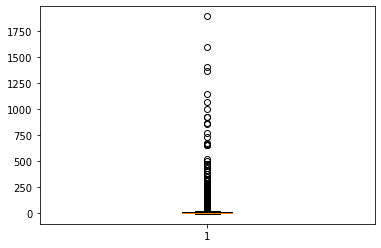

In [155]:
plt.boxplot(emi)

In [157]:
emi = dat.EMISSION
q1 = np.percentile(emi, 25)
q3 = np.percentile(emi, 75)
iqr = q3-q1

ls_outlier = []
for i in emi:
    if i > q3 + (1.5*iqr) or i < q1 - (1.5*iqr):
        ls_outlier.append(i)

len(ls_outlier)


6935

In [158]:
dat = dat.drop(index=dat[dat.EMISSION.isin(ls_outlier)].index)

{'whiskers': [<matplotlib.lines.Line2D at 0x24a9ee0e128>,
 'caps': [<matplotlib.lines.Line2D at 0x24a9ee0e780>,
 'boxes': [<matplotlib.lines.Line2D at 0x24a9f1c33c8>],
 'medians': [<matplotlib.lines.Line2D at 0x24a9ee0e8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x24a9f1b16a0>],
 'means': []}

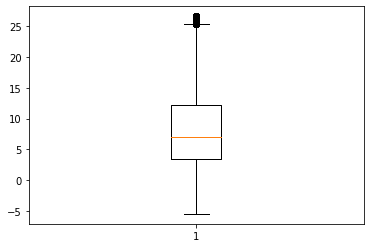

In [159]:
plt.boxplot(dat.EMISSION)

In [160]:
emi_dat = dat[['EMISSION','R_AGE', 'OCCAT','HHFAMINC','HHSIZE','NUMADLT', 'NUMCHD']]

# Part 1 Decision tree for demographic data

In [163]:
# values = StandardScaler().fit_transform(emi_dat.values).astype('float32')
values = emi_dat.values.astype('float32')

names = emi_dat.columns[1:]
print(values)

[[ 4.925645  55.         4.        ...  2.         2.         0.       ]
 [ 8.644916  82.         4.        ...  2.         2.         0.       ]
 [ 2.6790912 39.         2.        ...  4.         2.         2.       ]
 ...
 [10.842317  39.         4.        ...  2.         2.         0.       ]
 [13.685145  35.         4.        ...  4.         1.         3.       ]
 [ 9.124762  59.         4.        ...  7.         4.         3.       ]]


In [164]:
Y = values[:,0]
X = values[:,1:]

In [115]:
rf = RandomForestRegressor(n_estimators = 100,
                            max_depth = 4,
                            bootstrap = True,
                            oob_score = True
                            )  
rf.fit(X, Y)  
print ("Features sorted by their score:")  
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names),   
             reverse=True))     


Features sorted by their score:
[(0.5983, 'HHFAMINC'), (0.1875, 'R_AGE'), (0.1064, 'OCCAT'), (0.0968, 'NUMCHD'), (0.008, 'HHSIZE'), (0.003, 'NUMADLT')]


In [116]:
# traning
X_train,X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)

In [117]:
# decision tree
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
             'min_samples_split': [4, 8, 12, 16, 20, 24, 28]} 

rt = tree.DecisionTreeRegressor()
rtcv = GridSearchCV(estimator=rt, param_grid=param_grid, 
                            scoring='neg_mean_absolute_error', cv=4) 

train_result = rtcv.fit(X=X_train, y=y_train)

print('Best: {} of {}'.format(train_result.best_score_, train_result.best_params_))

Best: -5.505714365864821 of {'max_depth': 6, 'min_samples_split': 28}


In [209]:
# best model
# rt_best = tree.DecisionTreeRegressor(max_depth = train_result.best_params_['max_depth'],min_samples_split= train_result.best_params_['min_samples_split'])
rt_best = tree.DecisionTreeRegressor(max_depth = 3,min_samples_split= train_result.best_params_['min_samples_split'])

rt_best.fit(X=X_train, y=y_train)
test_result = rt_best.predict(X_test)

print("MAE:")
print(metrics.explained_variance_score(y_test,test_result))

print("MSE:")
print(metrics.mean_absolute_error(y_test,test_result))

MAE:
0.01852917271254495
MSE:
5.538706259558778


In [210]:
# result visualization
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=500)
tree.plot_tree(rt_best,
               feature_names = names, 
               filled = True)
fig.savefig('imagename.png')

In [120]:
# random forest

In [121]:
param_grid = {
    'max_depth':[5, 6, 7, 8],    
    'n_estimators':[11,13,15], 
    'max_features':[0.3,0.4,0.5],
    'min_samples_split':[4,8,12,16] 
}


rrf = RandomForestRegressor()
rrf_cv = GridSearchCV(estimator=rrf, param_grid=param_grid,
                      scoring='neg_mean_absolute_error', cv=4)
train_rst_rrf = rrf_cv.fit(X_train, y_train)

print('Best: {} of {}'.format(train_rst_rrf.best_score_, train_rst_rrf.best_params_))

Best: -5.492308588497979 of {'max_depth': 7, 'max_features': 0.5, 'min_samples_split': 4, 'n_estimators': 15}


In [122]:
# best model
rrf_best = RandomForestRegressor(max_depth = train_rst_rrf.best_params_['max_depth'],
                                 min_samples_split = train_rst_rrf.best_params_['min_samples_split'],
                                 n_estimators = train_rst_rrf.best_params_['n_estimators'],
                                 max_features = train_rst_rrf.best_params_['max_features'])

rrf_best.fit(X=X_train, y=y_train)
test_result = rrf_best.predict(X_test)

print("MAE:")
print(metrics.explained_variance_score(y_test,test_result)) 


print("MSE:")
print(metrics.mean_absolute_error(y_test,test_result)) 



MAE:
0.02178878424045294
MSE:
5.525127823239852


In [123]:
print ("Features sorted by their score:")  
print (sorted(zip(map(lambda x: round(x, 4), rrf_best.feature_importances_), names),   
             reverse=True))     

Features sorted by their score:
[(0.3936, 'HHFAMINC'), (0.2378, 'R_AGE'), (0.1698, 'OCCAT'), (0.0848, 'HHSIZE'), (0.0663, 'NUMCHD'), (0.0476, 'NUMADLT')]


In [30]:
# result visualization
import os
os.environ['PATH'] += os.pathsep + 'C:/Program Files/Graphviz/bin'

for index, model in enumerate(rrf_best.estimators_):
    filename = 'pca_{}.pdf'.format(index)
    tree_dat = tree.export_graphviz(model, 
                                    out_file=None,
                                    feature_names=names,
                                    class_names='Emission',
                                    filled=True,
                                    rounded=True,
                                    special_characters=True)
    graphs = pydotplus.graph_from_dot_data(tree_dat)

    Image(graphs.create_png())
    graphs.write_pdf(filename)
    

# Part 2 Residual regression for distance to work

In [165]:
Y_rt = rt_best.predict(X)

In [177]:
residuals = Y - Y_rt

(array([6.0000e+00, 7.9460e+03, 2.3519e+04, 1.9763e+04, 1.3892e+04,
        9.2720e+03, 6.0390e+03, 3.8850e+03, 2.5910e+03, 2.8800e+02]),
 array([-14.55444504, -11.0153057 ,  -7.47616636,  -3.93702702,
         -0.39788767,   3.14125167,   6.68039101,  10.21953035,
         13.75866969,  17.29780903,  20.83694837]),
 <BarContainer object of 10 artists>)

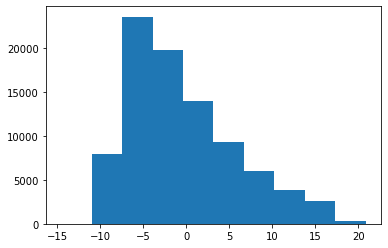

In [178]:
plt.hist(residuals)

In [179]:
np.corrcoef(residuals, dat.DISTTOWK17.values)

array([[1.        , 0.05512839],
       [0.05512839, 1.        ]])

In [176]:
dat.DISTTOWK17.values

array([ 8.11, 11.62,  1.65, ..., 12.5 , 10.57, 11.41])

In [198]:
lr = LinearRegression()
lr.fit(dat.DISTTOWK17.values.reshape((-1, 1)), residuals)

print('coefficient of determination:', lr.score(dat.DISTTOWK17.values.reshape((-1, 1)), residuals))

coefficient of determination: 0.003039139521122669


In [199]:
# traning
X_dis=dat.DISTTOWK17.values.reshape((-1, 1))
Y_dis=residuals
Xd_train,Xd_test, yd_train, yd_test = train_test_split(X_dis, Y_dis, test_size=0.25, random_state=12345)

In [208]:
# best model
rt_dis = tree.DecisionTreeRegressor(max_depth = 3,min_samples_split= train_result.best_params_['min_samples_split'])

rt_dis.fit(X=Xd_train, y=yd_train)
dis_result = rt_dis.predict(Xd_test)


In [207]:
# result visualization
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=500)
tree.plot_tree(rt_dis,
               feature_names = ['distance'], 
               filled = True)
fig.savefig('distance_to work.png')

In [190]:
residuals.reshape(residuals.shape[0],1)

array([[-4.36936811],
       [-0.6500974 ],
       [-7.29100801],
       ...,
       [ 1.54730364],
       [ 3.71504616],
       [-0.09443797]])